* 1st: compute position selectivity
* 2nd: get baseline and selectivity fr 
* 3rd: compute activation index

In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from ephysvibe.trials import align_trials, select_trials

In [2]:
def get_selectivity_info2(neu: NeuronData):
    win = 100
    res = {}
    res["nid"] = neu.get_neuron_id()

    inout_fr = []
    inout_sp = []
    for inout in ["in", "out"]:
        sp = getattr(neu, "sample_on_" + inout)
        inout_sp.append(sp)
        fr = firing_rate.moving_average(data=sp, win=100, step=1)[:, :-win]  #
        inout_fr.append(fr)

    pos_lat, pos_score, pos_p = smetrics.get_selectivity(
        inout_fr[0], inout_fr[1], win=75, scores=True
    )
    if np.isnan(pos_lat):
        pos_selec = np.nan
        activation_in = np.nan
        activation_out = np.nan
    else:

        blin = np.mean(inout_sp[0][:,100:300])
        samplein = np.mean(inout_sp[0][:,pos_lat:pos_lat+150])
        activation_in = (samplein-blin)/(blin+samplein)
        blout = np.mean(inout_sp[1][:,100:300])
        sampleout = np.mean(inout_sp[1][:,pos_lat:pos_lat+150])
        activation_out = (sampleout-blout)/(blout+sampleout)

        if pos_score[pos_lat] > 0:
            pos_selec = "in"
        else:
            pos_selec = "out"

    res["pos_lat"] = pos_lat
    res["pos_selec"] = pos_selec
    res["pos_score"] = pos_score
    res["pos_p"] = pos_p
    res["activation_in"] = activation_in
    res["activation_out"] = activation_out

    return res


In [3]:
def get_selectivity_info(neu: NeuronData):
    win = 100
    res = {}
    res["nid"] = neu.get_neuron_id()

    inout_fr = []
    inout_sp = []
    for inout in ["in", "out"]:
        sp = getattr(neu, "sample_on_" + inout)
        inout_sp.append(sp)
        fr = firing_rate.moving_average(data=sp, win=100, step=1)[:, :-win]  #
        inout_fr.append(fr)

    pos_lat, pos_score, pos_p = smetrics.get_selectivity(
        inout_fr[0], inout_fr[1], win=75, scores=True
    )
    if np.isnan(pos_lat):
        pos_selec = np.nan
        activation_in = np.nan
        activation_out = np.nan
    else:
        bl = np.concatenate((inout_sp[0][:,100:300],inout_sp[1][:,100:300]),axis=0)
        blmean = np.mean(bl) 
        samplein = np.mean(inout_sp[0][:,pos_lat:pos_lat+150]) 
        sampleout = np.mean(inout_sp[1][:,pos_lat:pos_lat+150]) 
        maxsample = np.max((samplein,sampleout))
        activation_in = (samplein-blmean)/(blmean+maxsample) 
        activation_out = (sampleout-blmean)/(blmean+maxsample) 

        if pos_score[pos_lat] > 0:
            pos_selec = "in"
        else:
            pos_selec = "out"

    res["pos_lat"] = pos_lat
    res["pos_selec"] = pos_selec
    res["pos_score"] = pos_score
    res["pos_p"] = pos_p
    res["activation_in"] = activation_in
    res["activation_out"] = activation_out
    res["ntr_in"] = inout_fr[0].shape[0]
    res["ntr_out"] =  inout_fr[1].shape[0]

    return res

In [4]:
def get_neu_align(path, params, sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
            select_block=it["select_block"],
            select_pos=it["inout"],
            event=it["event"],
            time_before=it["time_before"],
            error_type=0,
        )
        endt = it["time_before"] + it["end"]
        stt = it["time_before"] + it["st"]
        setattr(neu, it["sp"], np.array(sp[:, :endt], dtype=it["dtype_sp"]))
        setattr(neu, it["mask"], np.array(mask, dtype=it["dtype_mask"]))
        setattr(neu, "st_" + it["event"] + "_" + it["inout"], np.array(stt, dtype=int))
        setattr(
            neu,
            "time_before_" + it["event"] + "_" + it["inout"],
            np.array(it["time_before"], dtype=int),
        )

    if ~sp_sample:
        setattr(neu, "sp_samples", np.array([]))

    return neu

In [5]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}
savepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/activation_index/"
popu_path = {
    # "lip": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_lip.h5",
    # "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_pfc.h5",
    # "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_v4.h5",
}

In [5]:
for area in areas:
    print(area)
    if not bool(popu_path):
        path = filepaths[area]
        neu_path = path + "*neu.h5"
        path_list = glob.glob(neu_path)

        params = [
            {
                "inout": "in",
                "sp": "sample_on_in",
                "mask": "mask_in",
                "event": "sample_on",
                "time_before": 300,
                "st": 0,
                "end": 1550,
                "select_block": 1,
                "win": 100,
                "dtype_sp": np.int8,
                "dtype_mask": bool,
            },
            {
                "inout": "out",
                "sp": "sample_on_out",
                "mask": "mask_out",
                "event": "sample_on",
                "time_before": 300,
                "st": 0,
                "end": 1550,
                "select_block": 1,
                "win": 100,
                "dtype_sp": np.int8,
                "dtype_mask": bool,
            },
        ]
        population_list = Parallel(n_jobs=-1)(
            delayed(get_neu_align)(neu, params) for neu in tqdm(path_list)
        )
        comment = str(params)
        population = PopulationData(population_list, comment=comment)
        print("Saving population.h5")
        population.to_python_hdf5(savepath + "population_selectivity_" + area + ".h5")
        population = PopulationData.from_python_hdf5(
            savepath + "population_selectivity_" + area + ".h5"
        )
    else:
        print("Reading population data")
        population = PopulationData.from_python_hdf5(popu_path[area])
    print("Computing selectivity")
    df_selectivity = population.execute_function(
        get_selectivity_info, n_jobs=-1, ret_df=True
    )

    df_selectivity.to_pickle(savepath + "population_selectivity_" + area + ".pkl")

lip


  0%|          | 0/530 [00:00<?, ?it/s]

100%|██████████| 530/530 [11:46<00:00,  1.33s/it]


Saving population.h5


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/activation_index/population_selectivity_lip.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [7]:
population.to_python_hdf5(savepath + "population_selectivity_" + area + ".h5")
population = PopulationData.from_python_hdf5(
    savepath + "population_selectivity_" + area + ".h5"
)

In [6]:
population = PopulationData.from_python_hdf5("population_selectivity_lip.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'population_selectivity_lip.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
def get_sorted_scores(score,latencies,pmask=None):
    shifts=np.where(np.isnan(latencies),0,latencies).astype(int)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_score = np.nanmean(align_trials.indep_roll(arr=score, shifts=-shifts, axis = 1)[:,:200],axis=1)
    mean_score[np.isnan(mean_score)]=0
    positive_mask = mean_score>=0
    negative_mask = mean_score<0

    positive_sorted_idx = np.argsort(latencies[positive_mask])
    negative_sorted_idx = np.argsort(latencies[negative_mask])

    sorted_neg_scores = score[negative_mask][negative_sorted_idx]
    sorted_pos_scores = score[positive_mask][positive_sorted_idx][::-1]
    sorted_scores = np.concatenate((sorted_neg_scores,sorted_pos_scores),axis=0)

    sorted_neg_latencies = latencies[negative_mask][negative_sorted_idx]
    sorted_pos_latencies = latencies[positive_mask][positive_sorted_idx][::-1]
    sorted_latencies = np.concatenate((sorted_neg_latencies,sorted_pos_latencies),axis=0)
    sorted_pmask=None
    if pmask is not None:
        sorted_neg_pmask = pmask[negative_mask][negative_sorted_idx]
        sorted_pos_pmask = pmask[positive_mask][positive_sorted_idx][::-1]
        sorted_pmask = np.concatenate((sorted_neg_pmask,sorted_pos_pmask),axis=0)

    return sorted_scores, sorted_latencies,sorted_pmask

In [8]:
def plot_latencies(df,lat_key,score_key,ax,max_len=1750,p_key=None):
    
    lat = df[score_key].values.tolist()
    if p_key is not None:
        p = df[p_key].values.tolist()
        padded_p = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in p]
        pmask = np.array(padded_p)>0.05
    else:
        pmask=None
    #lists = [lst if isinstance(lst, np.ndarray) else np.array([]) for lst in lat]
    padded_lists = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in lat]
    score=np.array(padded_lists)
    latencies = df[lat_key].values
    sorted_scores, sorted_latencies,pmask = get_sorted_scores(score,latencies,pmask)
    sns.heatmap(sorted_scores, vmin=-1, vmax=1, cmap='PiYG',ax=ax,mask=pmask)
    ax.scatter(sorted_latencies,np.arange(len(sorted_latencies))+0.5,s=0.4,color='k')
    x_ticks = np.arange(0,sorted_scores.shape[1],50)
    ax.set_xticks(x_ticks)
    _=ax.set_xticklabels(x_ticks- 300 )
    ax.vlines([300,450+300,850+300],ax.get_ylim()[0],ax.get_ylim()[1],'k','--')
    ax.set_title(lat_key)
    return latencies

In [36]:
print("Computing selectivity")
df_selectivity = population.execute_function(
    get_selectivity_info, n_jobs=-1, ret_df=True
)

Computing selectivity


  2%|▏         | 8/530 [00:00<00:07, 71.00it/s]

KeyboardInterrupt: 

In [33]:
df_selectivity.to_pickle("population_selectivity_test" + ".pkl")

In [37]:
df_selectivity=pd.read_pickle("population_selectivity_test" + ".pkl")

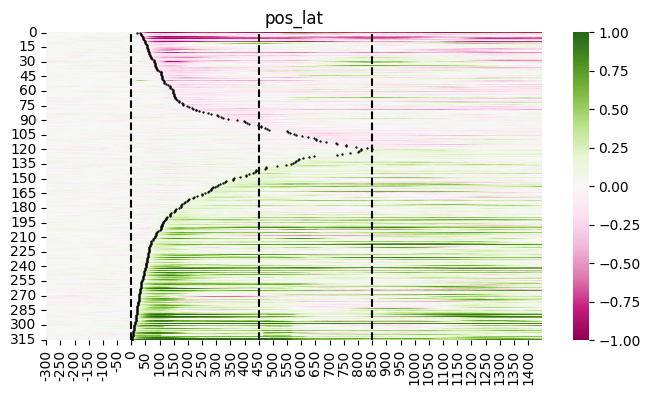

In [70]:
max_len=1750
df_sel=df_selectivity[np.logical_and(df_selectivity['pos_lat']>0+300,df_selectivity['pos_lat']<850+300)]
f,ax=plt.subplots(figsize=(8,4),sharex=True)
latencies = plot_latencies(df_sel,lat_key='pos_lat',score_key='pos_score',ax=ax)

In [67]:
area='lip'

Text(0.5, 1.0, 'LIP')

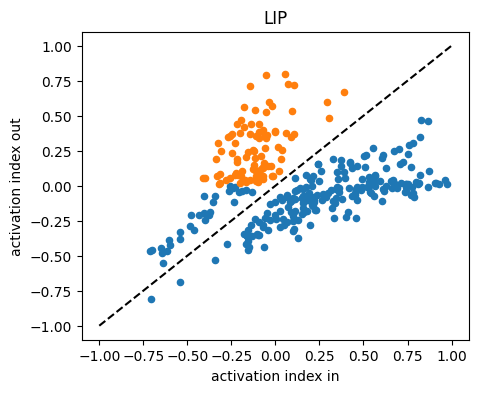

In [68]:
f,ax=plt.subplots(figsize=(5,4))
mask = np.logical_and(
    df_sel["activation_out"] > df_sel["activation_in"], (df_sel["activation_out"]) > 0
)
notmask=~mask
ax.scatter(df_sel[notmask]["activation_in"].values, df_sel[notmask]["activation_out"].values,s=20)
ax.scatter(df_sel[mask]["activation_in"].values, df_sel[mask]["activation_out"].values,s=20)
ax.plot([-1, 1], [-1, 1], "k--")
ax.set_xlabel("activation index in")
ax.set_ylabel("activation index out")
ax.set_title(area.upper())

In [15]:
#df_sel[df_sel['nid']=='good2LIP2023-02-27_10-50-03Riesling']

In [16]:
len(aa)

32

In [17]:
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "",
    "v4": "",
}
path = filepaths['lip']
neu_path = path + "*neu.h5"
path_list = glob.glob(neu_path)

for path in path_list:
    neu = NeuronData.from_python_hdf5(path)
    nid = neu.get_neuron_id()
    if nid in aa['nid'].values:
        fig = neu.plot_sp_b1()
        s_path = os.path.normpath(path).split(os.sep)
        ss_path = s_path[-1][:-7]
        fig.savefig('plots/'+ss_path + '.png',format='png',bbox_inches="tight", transparent=False)
        plt.close(fig)

c:\users\camil\documents\int\code\ephysvibe\ephysvibe\structures\neuron_data.py:382: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2[i_ax].scatter(


In [9]:
path = filepaths['lip']
neu_path = path + "*neu.h5"
path_list = glob.glob(neu_path)

for path in path_list:
    neu = NeuronData.from_python_hdf5(path)
    nid = neu.get_neuron_id()

    fig = neu.plot_sp_b1()
    s_path = os.path.normpath(path).split(os.sep)
    ss_path = s_path[-1][:-7]

    plt.close(fig)

AttributeError: 'NeuronData' object has no attribute 'rf_loc'